# Matrix Factorization 
### Application to an auditory fMRI dataset

### Tutorial Objectives

In this tutorial, we'll apply non-negative matrix factorization to an auditory fMRI data where participants listened to 165 natural sounds.
Here, we will:

1.	Load the preprocessed fMRI data and understand the data attributes and perform some basic visualizations <br>
2.	Apply and compare two different versions of the non-negative matrix factorization algorithm <br>
3.  Plot how the reconstruction error varies as a a function of the number of components <br>
4.  Interpret the response profiles of the resulting components to search for music and speech-selective neural populations <br>

<b>Motivation: </b>When we measure voxel response with fMRI, we measure an aggregated activity across hundreds of thousands of neurons. Presumably, there are a relatively small number of types of neural populations in these voxels. Each of these neural population will have a distinctive response profile over the sound set.
And voxels have different proportions of the different neural population types.
But what we measure in an fMRI experiment is the voxel’s response to sounds and our goal is to recover the response profiles of different neural populations and their anatomical proportions within every voxel (i.e. to demix the voxel responses).  


In [1]:
# Installing the required libraries
!pip install playsound
!pip install nimfa

In [2]:
import scipy.io as sio
import nimfa 
from playsound import playsound
import numpy as np
import matplotlib.pyplot as plt 
import glob, os, requests
import pandas as pd
import seaborn as sns

### Downloading the data

In [3]:
#@title Data retrieval

fname = "data.zip"
url = "https://osf.io/uhkez/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Load data and understand the data attributes

In [5]:
# Load data 
data = sio.loadmat('data/data_matrix.mat')

In [6]:
# Check data attributes 
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'D', 'categories', 'category_labels', 'component_names', 'stim_names', 'subject_indices'])

In [7]:
# Load filepaths of all stimuli
wav_dir = 'data/stimuli/wav'

stim_names = np.concatenate(data['stim_names'][0],0) 
stim_paths = np.array(["%s/%s.wav" % (wav_dir, name) for name in stim_names])

In [10]:
len(stim_paths), data['D'].shape

(165, (165, 11065, 3))

In [12]:
# Load the category labels of all sounds
labels = pd.read_csv('data/stimuli/category_labels.csv', index_col = 'stimulus')
np.unique(labels)

array(['AniNonVoc', 'AniVoc', 'EngSpeech', 'EnvSound', 'ForSpeech',
       'HumNonVoc', 'HumVoc', 'Mechanical', 'Music', 'Nature', 'Song'],
      dtype=object)

In [13]:
# Order the labels based on stimulus names 
categories = labels.loc[stim_names, 'label'].values

In [15]:
# Play sample sounds from the dataset
idx = 90
stim_path, category = stim_paths[idx], categories[idx]
print('Playing sound from the %s category' % category)
playsound(stim_path)

Playing sound from the AniNonVoc category


<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>(a). Average the fMRI responses across repetitions to create the data matrix  </b><br>
    <b>(b). Visualize the response of an example voxel to all sounds  </b><br>
</div>

In [16]:
# (a)
brain_data = np.nanmean(data['D'], -1)
brain_data.shape

(165, 11065)

<StemContainer object of 3 artists>

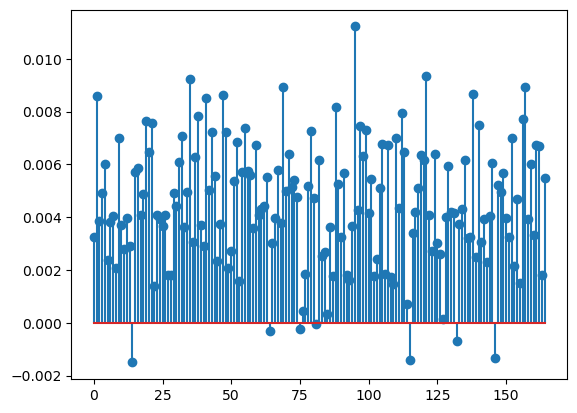

In [17]:
# (b)
plt.stem(brain_data[:,0])

### Apply two versions of NMF on the data <br>
(a) Standard NMF using `nimfa.Nmf` <br>
(b) Sparse NMF using `nimfa.Snmf`

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>As seen from the visualization above, voxel responses can sometimes be negative. To apply NMF (or its variants) on the data, we need non-negative data. 
To make the data matrix suitable for NMF so that it contains all positive entries, we can perform a baseline shift of voxel responses by subtracting the minimum response of each voxel (across all stimuli) from its responses to all stimuli. 
    In the following cell, perform this operation and store the result in a variable `nn_data`</b> 
</div>

In [18]:
# Handling the non-negative entries in the data 
nn_data = brain_data - brain_data.min(0)
np.min(nn_data)

0.0

##### Here, we will apply both the NMF methods on your non-negative data and compute the reconstruction error in each case 

In [19]:
n_components = 10
standard_nmf = nimfa.Nmf(nn_data, seed="nndsvd", rank=n_components, max_iter=12, update='euclidean', objective='fro')
standard_nmf_fit = standard_nmf()

print('Standard NMF RSS: %5.4f' % standard_nmf_fit.fit.rss())

snmf = nimfa.Snmf(nn_data, seed="nndsvd", rank=n_components, max_iter=12, version='r',
                  eta=1., beta=1e-4, i_conv=10, w_min_change=0)
snmf_fit = snmf()
print('Sparse NMF RSS: %5.4f' % snmf_fit.fit.rss())


Standard NMF RSS: 12.2705
Sparse NMF RSS: 9.5507


_Q. Which one is better?_

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>Use the better NMF approach and plot the reconstruction error (residual sum of squares) as a function of the number of components, varying the component number from 1 through 10  </b><br>
</div>

### Selecting the number of components

In [20]:
rss = []
n_range = range(1,11)
for n_components in n_range:
    nmf = nimfa.Snmf(nn_data, seed="nndsvd", rank=n_components, max_iter=12, version='r',
                      eta=1., beta=1e-4, i_conv=10, w_min_change=0)
    nmf_fit = nmf()
    rss.append(nmf_fit.fit.rss())

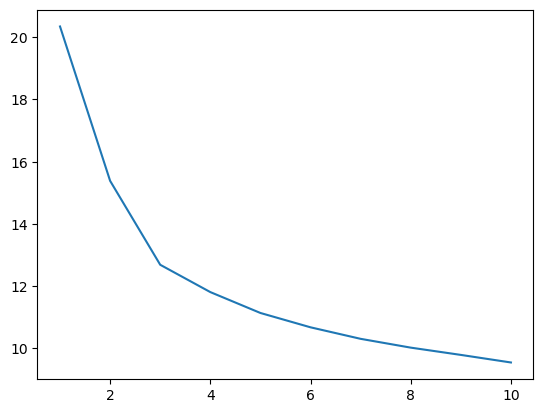

In [21]:
# Plot the reconstruction error as a function of the number of components
plt.plot(n_range, rss)

_Q. What can you conclude from this plot?_

### Applying NMF with the selected number of components

In [22]:
n_components = 6
snmf = nimfa.Snmf(nn_data, seed="nndsvd", rank=n_components, max_iter=12, version='l',
                      eta=1., beta=1e-4, i_conv=10, w_min_change=0)
snmf_fit = snmf()

In [23]:
# Extract the response profile matrix and the component weight matrix 
response_profile = np.asarray(snmf_fit.basis().T)
voxel_weight = np.asarray(snmf_fit.coef())

In [24]:
# Check the shape of the extracted low-dimensional matrices 
voxel_weight.shape, response_profile.shape

((6, 11065), (6, 165))

### Interpreting the response profiles of components 

<div class="alert alert-success"> <b>*** Tasks *** </b><br>
    <b>a. Visualize the response profile of all components using the function below and try to infer if there are indeed music and speech-selective neural populations  </b><br>
    <b>b. Play the top 10 sounds for the music and speech-selective components </b> 
</div>

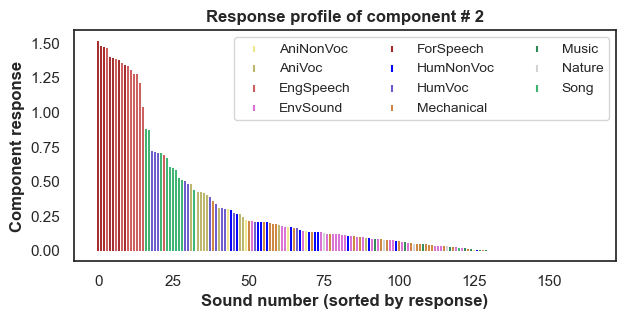

In [27]:
def visualize_component_response(idx = 0):
    
    sorted_categories = categories[np.argsort(response_profile[idx])][::-1]
    sorted_response = np.sort(response_profile[idx])[::-1]
    
    sns.set(font_scale=1, style = 'white') 
    
    colors = ['khaki', 'darkkhaki', 'indianred', 'orchid', 'brown', 'blue', 'slateblue', 'peru', 'seagreen', 'lightgray', 'mediumseagreen']
    
    fig, ax = plt.subplots(figsize = (7,3))
    for loc, cat_name in enumerate(np.unique(sorted_categories)): 
        markers, stems, base = plt.stem(np.where(sorted_categories == cat_name)[0], sorted_response[sorted_categories==cat_name], colors[loc], basefmt=" ", label=cat_name, markerfmt=" ")
        plt.setp(stems, 'linewidth', 1.4)
        
    plt.legend(ncol = 3, fontsize = 10)
    plt.xlabel('Sound number (sorted by response)', fontweight = 'bold', fontsize = 12);
    plt.ylabel('Component response', fontweight = 'bold', fontsize = 12)
    plt.title('Response profile of component # %d' % idx, fontweight = 'bold', fontsize = 12); 

visualize_component_response(idx = 2)

In [31]:
# Play top 10 sounds of the music and speech-speech selective components 
for i in range(10):
    playsound(stim_paths[np.argsort(response_profile[2])][::-1][i])

In [33]:
import os
os.getcwd()

'/Users/meenakshi/Desktop/nmf_tutorial'

#### Acknowledgements 
This dataset of fMRI responses to auditory sounds was collected by Sam Norman-Haignere and released as part of the following publication: 
Norman-Haignere, Sam, Nancy G. Kanwisher, and Josh H. McDermott. "Distinct cortical pathways for music and speech revealed by hypothesis-free voxel decomposition." Neuron 
                                                                          